# TP SVM

In [4]:
# global imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import qpsolvers

In [5]:
#remove warnings
import warnings
warnings.filterwarnings("ignore")

### 0. Give a first validity domain of your forecoming model

The models are able to predict a class into {-1, 1} from a vector X belonging to R2

### 1. Begin with the classification problem in the case of linearly separable classes, ie. yk = 1 or -1. 

![Frist situation](./Figure%20of%20first%20situation.png)

We are in the first case of the course, the primal is :

![Primal](./Primal%20problem.png)

In this case, the margin is equal to :
* Margin(w) = 2 / Norm(w)

### Step 1 : create the two clusters

First, set the points

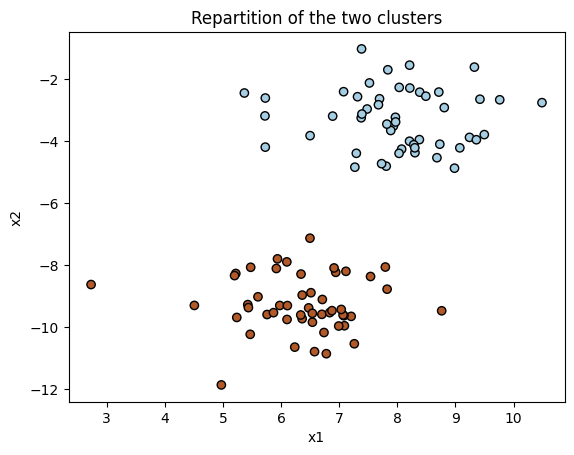

In [6]:
# Generate the two classes and affect the value -1 and 1 to the labels
X, y = make_blobs(n_samples=100, centers=2, random_state=6)
y[y == 0] = -1

# Plot the two clusters
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, marker='o', edgecolors='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Repartition of the two clusters')
plt.show()

According to the course, the dual is :
* max 𝑔(𝜆) = −1/2 * 𝜆.𝑇(𝐴𝐴.𝑇)𝜆 + 1.𝑇 𝜆
* 𝜆 ≥ 0
* 𝑦.𝑇 𝜆 = 0


The goal is to solve the dual to get 𝜆 and then compute w = −𝐴.𝑇 𝜆

In [7]:
# Define the matrices and vectors
A = -np.multiply(y.reshape(-1, 1), X)
P = np.dot(A, A.T)
q = -np.ones(len(X))
G= None
h = None
Aeq = y.reshape(1, -1) # y is a vector, we need to reshape it to a matrix
beq = np.array([0.])
lb = np.zeros(len(X))

# solve the dual problem
lambdas = qpsolvers.solve_qp(P, q, G, h, Aeq, beq, lb, solver='osqp')

Now we have lambda, we can find w with the previous formula

In [8]:
# compute w = −𝐴.𝑇 𝜆
w_star = -np.dot(A.T, lambdas)

What is the role of Complementary Slackness Conditions

* The Complementary Slackness Conditions ensure that all the indexes where lamba_k is strictly positive : the point X_k is a support vector.

Which are the "important" samples (support vectors) ?

* With the previous connditions : the support vectors are important when the lambda_i associated is strictly greater than 0.

Write down all the formulas as a function of dot product and the dual variable z*.

* Finally, the separator of the two classes is :

![Separator](./Marge%20separator.png)

Give a method for calculating the intercept w0. (b in our Labwork)

compute b = 𝑦 − 〈𝑤, 𝑥〉

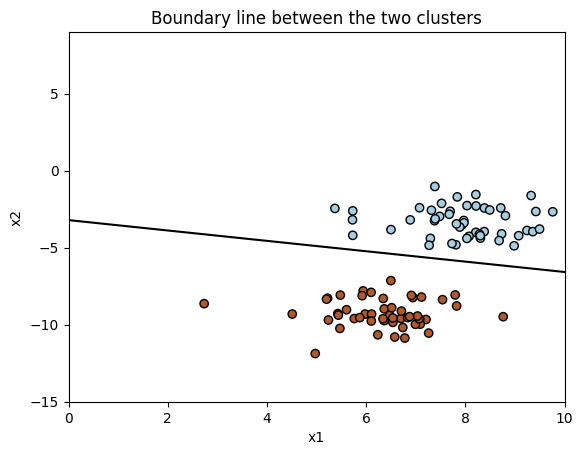

In [9]:
# plot the boundary line 〈𝑤, 𝑥〉 + 𝑏 = 0

# compute b = 𝑦 − 〈𝑤, 𝑥〉
b = y - np.dot(X, w_star)

# compute the two lines
x1 = np.linspace(-100000, 100000, 100)
x2 = -w_star[0] / w_star[1] * x1 - b / w_star[1]

# plot the two lines
plt.plot(x1, x2, 'k-')

# restrict the plot area where are the points
plt.xlim([0, 10])
plt.ylim([-15, 9])

# plot the two clusters
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, marker='o', edgecolors='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Boundary line between the two clusters')
plt.show()

### Make the classifier by creating training and test points

Thanks to that we can create a classifier to get the class of each point by computing the difference with the boundary

In [10]:
# Create SVMModelEx1 structure
SVMModelEx1 = {
    'w_star': w_star,
    'b': b,
    'support_vectors': X,
    'support_vectors_labels': y,
}

# Save the SVMModelEx1 structure using pickle
import pickle

with open('SVMModelEx1.pkl', 'wb') as file:
    pickle.dump(SVMModelEx1, file)

In [11]:
# Load SVMModelEx1 structure
with open('SVMModelEx1.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Extract relevant components
w_star_loaded = loaded_model['w_star']
b_loaded = loaded_model['b']
support_vectors_loaded = loaded_model['support_vectors']
support_vectors_labels_loaded = loaded_model['support_vectors_labels']

Write the predicting function svmprediction with inputs SVMModel and a new sample x

In [12]:
# svmprediction function
def svmprediction(SVMModel, x):
    """
    Predict the class label for a new sample x using the SVMModel.

    Parameters:
    - SVMModel: A dictionary containing the SVM model information.
    - x: The new sample for prediction.

    Returns:
    - Prediction label (1 or -1).
    """
    w_star = SVMModel['w_star']
    b = SVMModel['b']

    decision_function = np.dot(x, w_star) + b

    prediction = np.sign(decision_function)

    return prediction

new_sample = np.array([2, 3])

prediction = svmprediction(SVMModelEx1, new_sample)

print(f"Prediction for the new sample {new_sample}: {prediction[0]}")

Prediction for the new sample [2 3]: -1.0


Plot figures

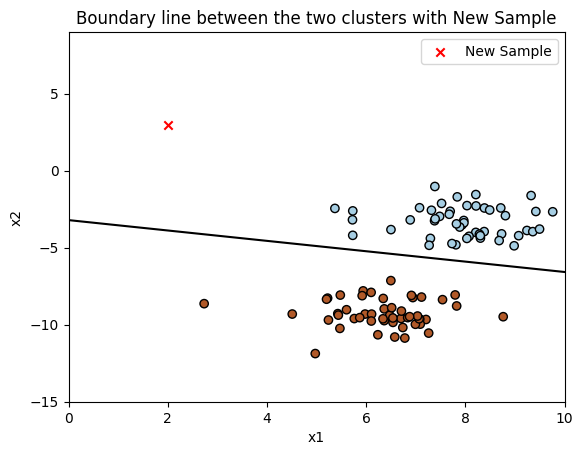

In [13]:
# Plotting the decision boundary and support vectors
x1 = np.linspace(-100000, 100000, 100)
x2 = -SVMModelEx1['w_star'][0] / SVMModelEx1['w_star'][1] * x1 - SVMModelEx1['b'] / SVMModelEx1['w_star'][1]

plt.plot(x1, x2, 'k-')
plt.xlim([0, 10])
plt.ylim([-15, 9])

plt.scatter(SVMModelEx1['support_vectors'][:, 0], SVMModelEx1['support_vectors'][:, 1],
            c=SVMModelEx1['support_vectors_labels'], cmap=plt.cm.Paired, marker='o', edgecolors='k')
plt.scatter(new_sample[0], new_sample[1], color='red', marker='x', label='New Sample')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Boundary line between the two clusters with New Sample')
plt.legend()
plt.show()

### Exercise 2 : with overlapsing clusters

### 1. Write down a SVM regression model (yk are real values) as a primal optimization problem. Write and solve the dual problem.

Primal Optimization Problem:
\begin{equation}
\min_{w, b, \xi} \frac{1}{2}||w||^2 + C \sum_{i=1}^{N} \xi_i
\end{equation}

subject to:
\begin{equation}
y_i - (w \cdot x_i + b) \leq \epsilon + \xi_i
\end{equation}

\begin{equation}
(w \cdot x_i + b) - y_i \leq \epsilon + \xi_i
\end{equation}

\begin{equation}
\xi_i \geq 0, \quad i = 1, \ldots, N
\end{equation}

Where:
- w is the weight vector,
- b is the bias term,
- xi_i are slack variables,
- y_i are the target values,
- x_i are the input feature vectors,
- epsilon is the epsilon-insensitive loss parameter,
- C is the regularization parameter.

Lagrangian:

\begin{equation}
\mathcal{L}(w, b, \xi, \alpha, \beta) = \frac{1}{2}||w||^2 + C \sum_{i=1}^{N} \xi_i - \sum_{i=1}^{N} \alpha_i (y_i - (w \cdot x_i + b) - \epsilon - \xi_i) - \sum_{i=1}^{N} \beta_i ((w \cdot x_i + b) - y_i - \epsilon - \xi_i) + \sum_{i=1}^{N} \gamma_i \xi_i
\end{equation}

Where:
- alpha_i, beta_i, gamma_i are Lagrange multipliers.

Dual Optimization Problem:

\begin{equation}
\max_{\alpha, \beta, \gamma} \sum_{i=1}^{N} \left( \epsilon \alpha_i - \frac{1}{2} \alpha_i \alpha_j (y_i - y_j) - \epsilon \beta_i - \frac{1}{2} \beta_i \beta_j (y_i - y_j) \right)
\end{equation}

subject to:
\begin{equation}
0 \leq \alpha_i, \beta_i, \gamma_i \leq C
\end{equation}

\begin{equation}
\sum_{i=1}^{N} (\alpha_i - \beta_i) = 0
\end{equation}

Observations about Support Vectors:
- The support vectors in regression are the data points for which \(\xi_i > 0\), i.e., the points that violate the margin or the epsilon-insensitive tube.
- These are the points that have a non-zero Lagrange multiplier (alpha_i > 0 or beta_i > 0).
- The role of support vectors is crucial because they determine the shape of the regression function.

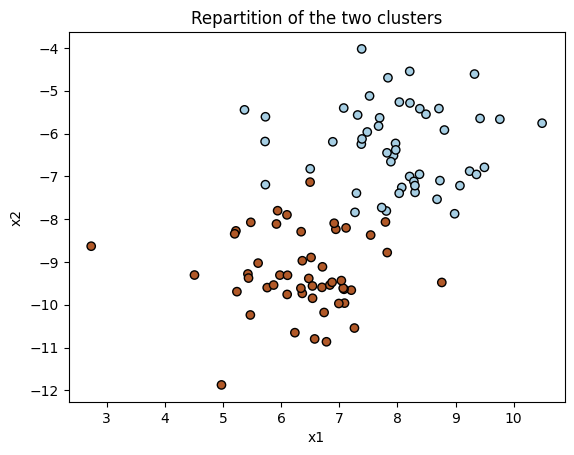

In [14]:
# Generate the two classes and affect the value -1 and 1 to the labels
X, y = make_blobs(n_samples=100, centers=2, random_state=6)
y[y == 0] = -1

# Move the points of the second cluster to have an overlapse
for i in range(0, len(X)):
    if y[i] == -1:
        X[i][1] = X[i][1] - 3

# Plot the two clusters
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, marker='o', edgecolors='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Repartition of the two clusters')
plt.show()

In this case, we add a constraint C :

In [15]:
# Constraint C of "tolerance" of the SVM
C = 1

Moving the value of C modify the "tolerance" of our SVM and gives several results

In [16]:
# Define the matrices and vectors
A = -np.multiply(y.reshape(-1, 1), X)
P = np.dot(A, A.T)
q = -np.ones(len(X))
G= None
h = None
Aeq = y.reshape(1, -1) # y is a vector, we need to reshape it to a matrix
beq = np.array([0.])
lb = np.zeros(len(X))
ub = np.ones(len(X)) * C

# solve the dual problem
lambdas = qpsolvers.solve_qp(P, q, G, h, Aeq, beq, lb, ub, solver='osqp')

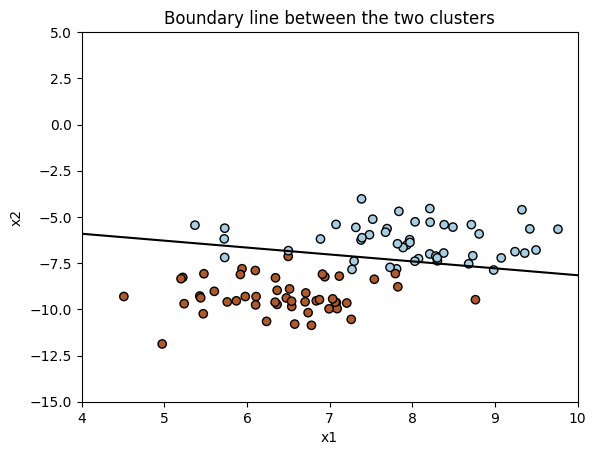

In [17]:
# compute w = −𝐴.𝑇 𝜆
w_star = -np.dot(A.T, lambdas)

# plot the boundary line 〈𝑤, 𝑥〉 + 𝑏 = 0

# compute b = 𝑦 − 〈𝑤, 𝑥〉
b = y - np.dot(X, w_star)

# compute the two lines
x1 = np.linspace(-100000, 100000, 100)
x2 = -w_star[0] / w_star[1] * x1 - b / w_star[1]

# plot the two lines
plt.plot(x1, x2, 'k-')

# restrict the plot area where are the points
plt.xlim([4, 10])
plt.ylim([-15, 5])

# plot the two clusters
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, marker='o', edgecolors='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Boundary line between the two clusters')
plt.show()

### 4. Give a second model by introducing kernels for the case of non linearirly separable problems.

In the case of non-linearly separable problems, introducing kernels allows the SVM to operate in a higher-dimensional feature space without explicitly computing the transformed feature vectors.

#### Dual Optimization Problem:

\begin{equation}
\max_{\alpha} \sum_{i=1}^{N} \alpha_i - \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_i \alpha_j y_i y_j K(x_i, x_j)
\end{equation}

subject to:

\begin{equation}
0 \leq \alpha_i \leq C, \quad i = 1, \ldots, N
\end{equation}

\begin{equation}
\sum_{i=1}^{N} \alpha_i y_i = 0
\end{equation}

Where:
- \(\alpha_i\) are the Lagrange multipliers,
- \(K(x_i, x_j)\) is the kernel function representing the inner product in the feature space.

#### Role of a Kernel and its Connection with Similarity:

A kernel function \(K(x_i, x_j)\) measures the similarity between two input vectors \(x_i\) and \(x_j\). It calculates the dot product of the vectors in a transformed feature space without explicitly computing the transformation. In other words, the kernel function provides a measure of similarity between input samples.

The choice of kernel determines the type of decision boundary the SVM will learn. Different kernels capture different types of relationships between data points, allowing the SVM to handle complex, non-linear decision boundaries.